# FIFA Players Classification

This notebook contains the code to train models for the FIFA Classification problem based on their attributes

## Step 1: Import libraries

Libraries we will be using:
- **tensorflow** and **keras**: APIs for neural network model construction and training
- **numpy**: Numerical python library.
- **pandas**: Will be used to work with dataframes from .csv files.
- **sklearn**: Will be used to modify the labels of the data and do some statistical modifications.
- **matplotlib**: Will be used to plot graphics.
- **time**: To measure training time.
- **datetime**: To get the datetime a new model is created and use that to create its name

In [1]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from datetime import datetime

## Step 2: Load data

We first define the path to our data

In [2]:
DATA_FOLDER = "../Data"

ATT_FILE = f"{DATA_FOLDER}/FootballPlayerPreparedCleanAttributes.csv"
IMPUTED_ATT_FILE = f"{DATA_FOLDER}/ImputedFootballPlayerPreparedCleanAttributes.csv"

ONE_HOT_LABEL_FILE = f"{DATA_FOLDER}/FootballPlayerOneHotEncodedClasses.csv"
IMPUTED_ONE_HOT_LABEL_FILE = f"{DATA_FOLDER}/ImputedFootballPlayerPreparedCleanAttributes.csv"

Specify training options:
- **IMPUTED_DATA**: We will use file with data imputed
- **TRAIN_RATE**: The amount of instances to use during training, it will also determine the dev and test instances number indirectly

In [3]:
IMPUTED_DATA = False    # Use imputed dataset
TRAIN_RATE = 0.8        # The division of the data for training, validation and test

Because our data has more than 10000, we will be using 80-10-10 split in our dataset:
- **80%** for training
- **10%** for validation/dev test
- **10%** for final test

In [4]:
if IMPUTED_DATA:
    attributes = pd.read_csv(ATT_IMPUTED_FILE)
    labels = pd.read_csv(ONE_HOT_LABEL_IMPUTED_FILE)
else:
    attributes = pd.read_csv(ATT_FILE)
    labels = pd.read_csv(ONE_HOT_LABEL_FILE)

n_total_instances = attributes.shape[0]
n_train_instances = int(n_total_instances * TRAIN_RATE)
n_dev_instances = int((n_total_instances - n_train_instances)/2)

instances_train = attributes.values[:n_train_instances]
labels_train = labels.values[:n_train_instances]

instances_dev = attributes.values[n_train_instances: n_train_instances + n_dev_instances]
labels_dev = labels.values[n_train_instances: n_train_instances + n_dev_instances]

print("instances_train:", instances_train.shape)
print("labels_train:", labels_train.shape)
print("instances_dev:", instances_dev.shape)
print("labels_dev:",labels_dev.shape)

instances_train: (12897, 17)
labels_train: (12897, 4)
instances_dev: (1612, 17)
labels_dev: (1612, 4)


## Step 3: Initialize variables
- **INPUT_SIZE**: The size of the training instances
- **OUTPUT_SIZE**: The number of possible classes
- **NUM_TRAINING_EXAMPLES**: The number of possible classes
- **NUM_DEV_EXAMPLES**: The number of validation/dev test instances

In [5]:
INPUT_SIZE = instances_train.shape[1]
OUTPUT_SIZE = labels_train.shape[1]
NUM_TRAINING_EXAMPLES = int(round(instances_train.shape[0]/1))
NUM_DEV_EXAMPLES = int(round(instances_dev.shape[0]/1))

## Step 4: Set hyperparameters

- **LEARNING_RATE** $\alpha$: The step size in the learning process
- **BATCH_SIZE**: The size of each batch
- **N_HIDDEN**: Number of neurons in the hidden.

The learning process stops when it reaches 20,000 learning iterations. An iteration comprises presenting the network *batch_size* learning examples and then adjusting the weights (parameters).

In [6]:
N_EPOCHS = 400
LEARNING_RATE = 0.001
BATCH_SIZE = 1024
ACTIVATION = "relu"
N_HIDDEN = [2048, 1024, 512, 256, 128, 64, 32]
REGULARIZER = keras.regularizers.l1(0.0001)
INITIALIZER = keras.initializers.he_normal(seed=None)
LOSS = tf.keras.losses.categorical_crossentropy
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=0.9, beta_2=0.999)
METRICS = ["categorical_accuracy"]

## Step 5: Build the model

In [7]:
def architecture1():
    model = keras.Sequential(name="Model")
    model.add(keras.layers.InputLayer(input_shape=(INPUT_SIZE,), batch_size=None))
    for neurons in N_HIDDEN:
        model.add(keras.layers.Dense(neurons, activation=ACTIVATION))
    model.add(keras.layers.Dense(OUTPUT_SIZE, activation="softmax"))
    
    model_name = "D512"
    return model, model_name


def architecture2():
    model = keras.Sequential(name="Model")
    model.add(keras.layers.InputLayer(input_shape=(INPUT_SIZE,),
                                      batch_size=None))
    for neurons in N_HIDDEN:
        model.add(keras.layers.Dense(neurons,
                                     activation=ACTIVATION,
                                     kernel_regularizer=REGULARIZER
                                    ))
        
    model.add(keras.layers.Dense(OUTPUT_SIZE, 
                                 activation="softmax"))
    
    model_name = "D128_D64_D32"
    return model, model_name

def architecture3():
    model = keras.Sequential(name="Model")
    model.add(keras.layers.InputLayer(input_shape=(INPUT_SIZE,),
                                      batch_size=None))
    
    for neurons in N_HIDDEN:
        model.add(keras.layers.Dense(neurons))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Activation(ACTIVATION))
        
    model.add(keras.layers.Dense(OUTPUT_SIZE,
                                 activation="softmax"
                                ))
    model_name = "D128_BN_D64_BN_D32_BN"
    return model, model_name

def architecture4():
    model = keras.Sequential(name="Model")
    model.add(keras.layers.InputLayer(input_shape=(INPUT_SIZE,),
                                      batch_size=None))
    
    for neurons in N_HIDDEN:
        model.add(keras.layers.Dense(neurons,
                                     kernel_regularizer=REGULARIZER,
                                     kernel_initializer=keras.initializers.HeNormal(seed=None),
                                     use_bias=False
                                     ))
    
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Activation(ACTIVATION))
        
    model.add(keras.layers.Dense(OUTPUT_SIZE,
                                 activation="softmax"
                                ))
    model_name = "D2048_BN_D1024_BN_D512_BN_D256_BN_D128_BN_D64_BN_D32_BN"
    return model, model_name


def compile_model(model):
    my_model.compile(loss=LOSS,
                     optimizer=OPTIMIZER,
                     metrics=METRICS)

In [8]:
my_model, model_name = architecture4()

In [9]:
compile_model(my_model)

## Step 6: Train the model

In [10]:
start_time = time.perf_counter()
history = my_model.fit(instances_train,
                       labels_train,
                       batch_size=BATCH_SIZE,
                       epochs=N_EPOCHS,
                       verbose=1,
                       validation_data=(instances_dev, labels_dev))
end_time = time.perf_counter()

Epoch 1/400
13/13 [==============================] - 3s 48ms/step - loss: 9.9708 - categorical_accuracy: 0.6826 - val_loss: 11.6353 - val_categorical_accuracy: 0.4423
Epoch 2/400
13/13 [==============================] - 0s 25ms/step - loss: 9.1429 - categorical_accuracy: 0.8016 - val_loss: 10.8945 - val_categorical_accuracy: 0.4504
Epoch 3/400
13/13 [==============================] - 0s 25ms/step - loss: 8.3690 - categorical_accuracy: 0.8118 - val_loss: 9.8373 - val_categorical_accuracy: 0.4560
Epoch 4/400
13/13 [==============================] - 0s 25ms/step - loss: 7.5502 - categorical_accuracy: 0.8251 - val_loss: 8.2425 - val_categorical_accuracy: 0.5050
Epoch 5/400
13/13 [==============================] - 0s 25ms/step - loss: 6.7793 - categorical_accuracy: 0.8316 - val_loss: 7.0800 - val_categorical_accuracy: 0.5806
Epoch 6/400
13/13 [==============================] - 0s 25ms/step - loss: 6.0805 - categorical_accuracy: 0.8365 - val_loss: 6.0742 - val_categorical_accuracy: 0.6979
Ep

13/13 [==============================] - 0s 25ms/step - loss: 1.3400 - categorical_accuracy: 0.8680 - val_loss: 1.7043 - val_categorical_accuracy: 0.7153
Epoch 51/400
13/13 [==============================] - 0s 25ms/step - loss: 1.3475 - categorical_accuracy: 0.8597 - val_loss: 1.7714 - val_categorical_accuracy: 0.7041
Epoch 52/400
13/13 [==============================] - 0s 25ms/step - loss: 1.3629 - categorical_accuracy: 0.8530 - val_loss: 1.8662 - val_categorical_accuracy: 0.6818
Epoch 53/400
13/13 [==============================] - 0s 25ms/step - loss: 1.3392 - categorical_accuracy: 0.8638 - val_loss: 1.6285 - val_categorical_accuracy: 0.7295
Epoch 54/400
13/13 [==============================] - 0s 25ms/step - loss: 1.2831 - categorical_accuracy: 0.8732 - val_loss: 1.6881 - val_categorical_accuracy: 0.7146
Epoch 55/400
13/13 [==============================] - 0s 25ms/step - loss: 1.2520 - categorical_accuracy: 0.8769 - val_loss: 1.6157 - val_categorical_accuracy: 0.7122
Epoch 56/40

13/13 [==============================] - 0s 25ms/step - loss: 0.8873 - categorical_accuracy: 0.9329 - val_loss: 1.4848 - val_categorical_accuracy: 0.7494
Epoch 100/400
13/13 [==============================] - 0s 25ms/step - loss: 0.8912 - categorical_accuracy: 0.9298 - val_loss: 1.4580 - val_categorical_accuracy: 0.7469
Epoch 101/400
13/13 [==============================] - 0s 25ms/step - loss: 0.8771 - categorical_accuracy: 0.9332 - val_loss: 1.4235 - val_categorical_accuracy: 0.7711
Epoch 102/400
13/13 [==============================] - 0s 25ms/step - loss: 0.8640 - categorical_accuracy: 0.9346 - val_loss: 1.4510 - val_categorical_accuracy: 0.7388
Epoch 103/400
13/13 [==============================] - 0s 24ms/step - loss: 0.8670 - categorical_accuracy: 0.9301 - val_loss: 1.6269 - val_categorical_accuracy: 0.7066
Epoch 104/400
13/13 [==============================] - 0s 24ms/step - loss: 0.8742 - categorical_accuracy: 0.9284 - val_loss: 1.4645 - val_categorical_accuracy: 0.7618
Epoch 

Epoch 148/400
13/13 [==============================] - 0s 25ms/step - loss: 0.5543 - categorical_accuracy: 0.9800 - val_loss: 1.6193 - val_categorical_accuracy: 0.7264
Epoch 149/400
13/13 [==============================] - 0s 25ms/step - loss: 0.5659 - categorical_accuracy: 0.9732 - val_loss: 1.6517 - val_categorical_accuracy: 0.7066
Epoch 150/400
13/13 [==============================] - 0s 25ms/step - loss: 0.5862 - categorical_accuracy: 0.9710 - val_loss: 1.5910 - val_categorical_accuracy: 0.7308
Epoch 151/400
13/13 [==============================] - 0s 25ms/step - loss: 0.6223 - categorical_accuracy: 0.9619 - val_loss: 1.4875 - val_categorical_accuracy: 0.7636
Epoch 152/400
13/13 [==============================] - 0s 25ms/step - loss: 0.6401 - categorical_accuracy: 0.9582 - val_loss: 1.6200 - val_categorical_accuracy: 0.7270
Epoch 153/400
13/13 [==============================] - 0s 25ms/step - loss: 0.6815 - categorical_accuracy: 0.9518 - val_loss: 1.5778 - val_categorical_accuracy:

Epoch 197/400
13/13 [==============================] - 0s 25ms/step - loss: 0.5141 - categorical_accuracy: 0.9670 - val_loss: 1.4269 - val_categorical_accuracy: 0.7624
Epoch 198/400
13/13 [==============================] - 0s 25ms/step - loss: 0.5201 - categorical_accuracy: 0.9667 - val_loss: 1.4308 - val_categorical_accuracy: 0.7537
Epoch 199/400
13/13 [==============================] - 0s 25ms/step - loss: 0.4988 - categorical_accuracy: 0.9750 - val_loss: 1.4658 - val_categorical_accuracy: 0.7674
Epoch 200/400
13/13 [==============================] - 0s 25ms/step - loss: 0.4928 - categorical_accuracy: 0.9757 - val_loss: 1.5257 - val_categorical_accuracy: 0.7531
Epoch 201/400
13/13 [==============================] - 0s 25ms/step - loss: 0.4938 - categorical_accuracy: 0.9741 - val_loss: 1.4624 - val_categorical_accuracy: 0.7581
Epoch 202/400
13/13 [==============================] - 0s 26ms/step - loss: 0.4751 - categorical_accuracy: 0.9801 - val_loss: 1.5009 - val_categorical_accuracy:

Epoch 246/400
13/13 [==============================] - 0s 25ms/step - loss: 0.3807 - categorical_accuracy: 0.9958 - val_loss: 1.4090 - val_categorical_accuracy: 0.7550
Epoch 247/400
13/13 [==============================] - 0s 25ms/step - loss: 0.3684 - categorical_accuracy: 0.9960 - val_loss: 1.4374 - val_categorical_accuracy: 0.7531
Epoch 248/400
13/13 [==============================] - 0s 25ms/step - loss: 0.3563 - categorical_accuracy: 0.9971 - val_loss: 1.4966 - val_categorical_accuracy: 0.7481
Epoch 249/400
13/13 [==============================] - 0s 25ms/step - loss: 0.3457 - categorical_accuracy: 0.9983 - val_loss: 1.5508 - val_categorical_accuracy: 0.7494
Epoch 250/400
13/13 [==============================] - 0s 25ms/step - loss: 0.3397 - categorical_accuracy: 0.9976 - val_loss: 1.4616 - val_categorical_accuracy: 0.7531
Epoch 251/400
13/13 [==============================] - 0s 24ms/step - loss: 0.3409 - categorical_accuracy: 0.9954 - val_loss: 1.4894 - val_categorical_accuracy:

Epoch 295/400
13/13 [==============================] - 0s 24ms/step - loss: 0.3699 - categorical_accuracy: 0.9840 - val_loss: 1.5681 - val_categorical_accuracy: 0.7655
Epoch 296/400
13/13 [==============================] - 0s 25ms/step - loss: 0.3697 - categorical_accuracy: 0.9836 - val_loss: 1.5434 - val_categorical_accuracy: 0.7605
Epoch 297/400
13/13 [==============================] - 0s 25ms/step - loss: 0.3745 - categorical_accuracy: 0.9833 - val_loss: 1.5203 - val_categorical_accuracy: 0.7674
Epoch 298/400
13/13 [==============================] - 0s 25ms/step - loss: 0.3883 - categorical_accuracy: 0.9760 - val_loss: 1.4933 - val_categorical_accuracy: 0.7643
Epoch 299/400
13/13 [==============================] - 0s 25ms/step - loss: 0.4188 - categorical_accuracy: 0.9669 - val_loss: 1.5959 - val_categorical_accuracy: 0.7370
Epoch 300/400
13/13 [==============================] - 0s 24ms/step - loss: 0.4342 - categorical_accuracy: 0.9650 - val_loss: 1.4284 - val_categorical_accuracy:

Epoch 344/400
13/13 [==============================] - 0s 25ms/step - loss: 0.3708 - categorical_accuracy: 0.9777 - val_loss: 1.5790 - val_categorical_accuracy: 0.7550
Epoch 345/400
13/13 [==============================] - 0s 25ms/step - loss: 0.3805 - categorical_accuracy: 0.9753 - val_loss: 1.5980 - val_categorical_accuracy: 0.7444
Epoch 346/400
13/13 [==============================] - 0s 24ms/step - loss: 0.3688 - categorical_accuracy: 0.9808 - val_loss: 1.5590 - val_categorical_accuracy: 0.7413
Epoch 347/400
13/13 [==============================] - 0s 25ms/step - loss: 0.3570 - categorical_accuracy: 0.9847 - val_loss: 1.5309 - val_categorical_accuracy: 0.7463
Epoch 348/400
13/13 [==============================] - 0s 25ms/step - loss: 0.3709 - categorical_accuracy: 0.9788 - val_loss: 1.5457 - val_categorical_accuracy: 0.7550
Epoch 349/400
13/13 [==============================] - 0s 25ms/step - loss: 0.3693 - categorical_accuracy: 0.9788 - val_loss: 1.5629 - val_categorical_accuracy:

Epoch 393/400
13/13 [==============================] - 0s 24ms/step - loss: 0.2859 - categorical_accuracy: 0.9968 - val_loss: 1.5476 - val_categorical_accuracy: 0.7550
Epoch 394/400
13/13 [==============================] - 0s 24ms/step - loss: 0.2870 - categorical_accuracy: 0.9951 - val_loss: 1.5108 - val_categorical_accuracy: 0.7605
Epoch 395/400
13/13 [==============================] - 0s 25ms/step - loss: 0.2894 - categorical_accuracy: 0.9934 - val_loss: 1.5632 - val_categorical_accuracy: 0.7643
Epoch 396/400
13/13 [==============================] - 0s 24ms/step - loss: 0.2925 - categorical_accuracy: 0.9932 - val_loss: 1.6375 - val_categorical_accuracy: 0.7444
Epoch 397/400
13/13 [==============================] - 0s 25ms/step - loss: 0.2875 - categorical_accuracy: 0.9949 - val_loss: 1.6439 - val_categorical_accuracy: 0.7531
Epoch 398/400
13/13 [==============================] - 0s 24ms/step - loss: 0.2827 - categorical_accuracy: 0.9957 - val_loss: 1.6843 - val_categorical_accuracy:

## Step 7: Analyze results

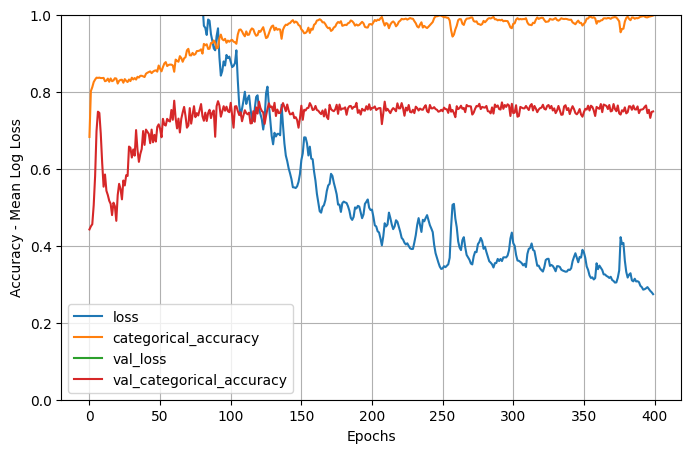

In [11]:
results=pd.DataFrame(history.history)
results.plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel ("Epochs")
plt.ylabel ("Accuracy - Mean Log Loss")
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [12]:
training_accuracy = round(results.categorical_accuracy.values[-1:][0]*100, 2)
val_accuracy = round(results.val_categorical_accuracy.values[-1:][0]*100, 2)
training_error = round((1 - results.categorical_accuracy.values[-1:][0])*100, 2)
test_error = round((1 - results.val_categorical_accuracy.values[-1:][0])*100, 2)
human_error = 5
bias = round(training_error - human_error, 2)
variance = round(test_error - training_error, 2)
training_time = round(end_time - start_time)
print("Training accuracy: ", training_accuracy, "%")
print("Validationa accuracy", val_accuracy, "%")
print("Error (training):", training_error, "%")
print("Error (test):", test_error, "%")
print("Bias:", bias)
print("Variance:", variance)
print("Time: ", training_time, "seconds")

Training accuracy:  99.8 %
Validationa accuracy 74.88 %
Error (training): 0.2 %
Error (test): 25.12 %
Bias: -4.8
Variance: 24.92
Time:  132 seconds


In [13]:
def draw_confusion_matrix(cm, categories, normalize=True):
    # Draw confusion matrix
    fig = plt.figure(figsize=[3*pow(len(categories), 0.5), 2*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    if normalize:
        cm = cm.astype('float') / np.maximum(cm.sum(axis=1)[:, np.newaxis], np.finfo(np.float64).eps)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=categories, yticklabels=categories, ylabel='Annotation', xlabel='Prediction')
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha="center", va="center", color="white" if cm[i, j] > thresh else "black", fontsize=int(12-pow(len(categories), 0.5)))
    fig.tight_layout()
    plt.show(fig)


51/51 [==============================] - 0s 3ms/step


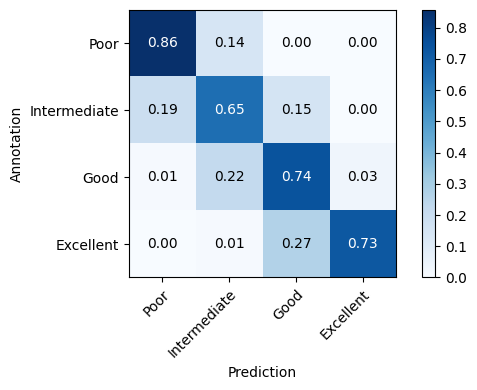

In [14]:
labels_pred = my_model.predict(instances_dev)
cm = confusion_matrix(np.argmax(labels_dev, axis=1), np.argmax(labels_pred, axis=1))
draw_confusion_matrix(cm, ["Poor", "Intermediate", "Good", "Excellent"])

## Step 8: Save results

In [15]:
RESULTS_FOLDER = "../Results"
RESULTS_FILE = f"{RESULTS_FOLDER}/models_performance.csv"

In [16]:
results_df = pd.read_csv(RESULTS_FILE, index_col = 0)

In [17]:
COLUMNS = [
    'model_name',
    'epochs',
    'learning_rate',
    'batch_size',
    'activation',
    'loss',
    'optimizer',
    'regularization',
    'initializer',
    'train_accuracy',
    'validation_accuracy',
    'bias',
    'variance',
    'training_time'
]

new_result = [[
    model_name,
    N_EPOCHS,
    LEARNING_RATE,
    BATCH_SIZE,
    ACTIVATION,
    "categorical_crossentropy",
    "ADAM b109 b20999",
    "l1 0.0001",
    "he_normal",
    training_accuracy,
    val_accuracy,
    bias,
    variance,
    training_time]]

new_result_df = pd.DataFrame(new_result, columns=COLUMNS)
concatenation = pd.concat([results_df, new_result_df], ignore_index=True)
concatenation.to_csv(RESULTS_FILE)


In [18]:
# last_five = results_df.tail(5)
last_five = concatenation.tail(5)
print(last_five)
print("\n---Metrics---")
print(last_five[["train_accuracy", "validation_accuracy", "bias", "variance", "training_time"]].describe())

                                           model_name  epochs  learning_rate  \
80  D2048_BN_D1024_BN_D512_BN_D256_BN_D128_BN_D64_...     400          0.001   
81  D2048_BN_D1024_BN_D512_BN_D256_BN_D128_BN_D64_...     400          0.001   
82  D2048_BN_D1024_BN_D512_BN_D256_BN_D128_BN_D64_...     400          0.001   
83  D2048_BN_D1024_BN_D512_BN_D256_BN_D128_BN_D64_...     400          0.001   
84  D2048_BN_D1024_BN_D512_BN_D256_BN_D128_BN_D64_...     400          0.001   

    batch_size activation                      loss         optimizer  \
80         256       relu  categorical_crossentropy  ADAM b109 b20999   
81         256       relu  categorical_crossentropy  ADAM b109 b20999   
82         256       relu  categorical_crossentropy  ADAM b109 b20999   
83         256       relu  categorical_crossentropy  ADAM b109 b20999   
84        1024       relu  categorical_crossentropy  ADAM b109 b20999   

   regularization  train_accuracy  validation_accuracy   bias  variance  \
80   

In [19]:
MODELS_FOLDER = "../Models"
save_name = f"{MODELS_FOLDER}/{model_name}-6.h5"
my_model.save(save_name)